# MVA - Homework 1 - Reinforcement Learning (2022/2023)

**Name:** DUVAL Denis

## Instructions

* The deadline is **November 10 at 11:59 pm (Paris time).**

* By doing this homework you agree to the late day policy, collaboration and misconduct rules reported on [Piazza](https://piazza.com/class/l4y5ubadwj64mb/post/6).

* **Mysterious or unsupported answers will not receive full credit**. A correct answer, unsupported by calculations, explanation, or algebraic work will receive no credit; an incorrect answer supported by substantially correct calculations and explanations might still receive partial credit.

* Answers should be provided in **English**.

# Colab setup

In [1]:
from IPython import get_ipython

if 'google.colab' in str(get_ipython()):
  # install rlberry library
  !pip install git+https://github.com/rlberry-py/rlberry.git@mva2021#egg=rlberry[default] > /dev/null 2>&1

  # install ffmpeg-python for saving videos
  !pip install ffmpeg-python > /dev/null 2>&1

  # packages required to show video
  !pip install pyvirtualdisplay > /dev/null 2>&1
  !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

  print("Libraries installed, please restart the runtime!")


Libraries installed, please restart the runtime!


In [2]:
# Create directory for saving videos
!mkdir videos > /dev/null 2>&1

# Initialize display and import function to show videos
import rlberry.colab_utils.display_setup
from rlberry.colab_utils.display_setup import show_video

In [3]:
# Useful libraries
import numpy as np
import matplotlib.pyplot as plt

# Preparation

In the coding exercises, you will use a *grid-world* MDP, which is represented in Python using the interface provided by the [Gym](https://gym.openai.com/) library. The cells below show how to interact with this MDP and how to visualize it.


In [4]:
from rlberry.envs import GridWorld

def get_env():
  """Creates an instance of a grid-world MDP."""
  env = GridWorld(
      nrows=5,
      ncols=7,
      reward_at = {(0, 6):1.0},
      walls=((0, 4), (1, 4), (2, 4), (3, 4)),
      success_probability=0.9,
      terminal_states=((0, 6),)
  )
  return env

def render_policy(env, policy=None, horizon=50):
  """Visualize a policy in an environment

  Args:
    env: GridWorld
        environment where to run the policy
    policy: np.array
        matrix mapping states to action (Ns).
        If None, runs random policy.
    horizon: int
        maximum number of timesteps in the environment.
  """
  env.enable_rendering()
  state = env.reset()                       # get initial state
  for timestep in range(horizon):
      if policy is None:
        action = env.action_space.sample()  # take random actions
      else:
        action = policy[state]
      next_state, reward, is_terminal, info = env.step(action)
      state = next_state
      if is_terminal:
        break
  # save video and clear buffer
  env.save_video('./videos/gw.mp4', framerate=5)
  env.clear_render_buffer()
  env.disable_rendering()
  # show video
  show_video('./videos/gw.mp4')


[INFO] OpenGL_accelerate module loaded 
[INFO] Using accelerated ArrayDatatype 
[INFO] Generating grammar tables from /usr/lib/python3.7/lib2to3/Grammar.txt 
[INFO] Generating grammar tables from /usr/lib/python3.7/lib2to3/PatternGrammar.txt 
/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [5]:
# Create an environment and visualize it
env = get_env()
render_policy(env)  # visualize random policy

# The reward function and transition probabilities can be accessed through
# the R and P attributes:
print(f"Shape of the reward array = (S, A) = {env.R.shape}")
print(f"Shape of the transition array = (S, A, S) = {env.P.shape}")
print(f"Reward at (s, a) = (1, 0): {env.R[1, 0]}")
print(f"Prob[s\'=2 | s=1, a=0]: {env.P[1, 0, 2]}")
print(f"Number of states and actions: {env.Ns}, {env.Na}")

# The states in the griworld correspond to (row, col) coordinates.
# The environment provides a mapping between (row, col) and the index of
# each state:
print(f"Index of state (1, 0): {env.coord2index[(1, 0)]}")
print(f"Coordinates of state 5: {env.index2coord[5]}")

Shape of the reward array = (S, A) = (31, 4)
Shape of the transition array = (S, A, S) = (31, 4, 31)
Reward at (s, a) = (1, 0): 0.0
Prob[s'=2 | s=1, a=0]: 0.04999999999999999
Number of states and actions: 31, 4
Index of state (1, 0): 6
Coordinates of state 5: (0, 6)


# Part 1 - Dynamic Programming

## Question 1.1

Consider a general MDP with a discount factor of $\gamma < 1$. Assume that the horizon is infinite (so there is no termination). A policy $\pi$ in this MDP
induces a value function $V^\pi$. Suppose an affine transformation is applied to the reward, what is
the new value function? Is the optimal policy preserved?



### **Answer**

Let $a, b$ two real scalars. The new reward is $r'=ar+b$. So for any policy $\pi$ at any state $s$:
$$ V'^\pi(s) = \mathbb{E}[\sum_{t=0}^{∞}{\gamma^tr'_t}|s_0=s, \pi] = a\mathbb{E}[\sum_{t=0}^{∞}{\gamma^tr_t}|s_0=s, \pi] + b\mathbb{E}[\sum_{t=0}^{∞}{\gamma^t}|s_0=s, \pi]$$
</br>
Hence:
$$ V'^\pi(s) = aV^\pi(s)+\frac{b}{1-\gamma}$$

From this it is easy to see that :
</br>
- if $a>0$ then the optimal policy is preserved.
</br>
- if $a<0$ then the optimal policy isn't preserved, moreover the 'minimal' policy is now the optimal one.
</br>
- if $a=0$ then any policy is optimal.

## Question 1.2

Consider an infinite-horizon $\gamma$-discounted MDP. We denote by $Q^*$ the $Q$-function of the optimal policy $\pi^*$. Prove that, for any function $Q(s, a)$ (which is **not** necessarily the value function of a policy), the following inequality holds for any state $s$:

$$
V^{\pi_Q}(s) \geq V^*(s) - \frac{2}{1-\gamma}||Q^*-Q||_\infty,
$$

where $||Q^*-Q||_\infty = \max_{s, a} |Q^*(s, a) - Q(s, a)|$ and $\pi_Q(s) \in \arg\max_a Q(s, a)$. Can you use this result to show that any policy $\pi$ such that $\pi(s) \in \arg\max_a Q^*(s, a)$ is optimal?

### **Answer**

Let $a=||Q^*-Q||_\infty$.
Let $s$ be any state.
We start by writing the definitions of $Q^*$ and $Q^{\pi_Q}$ :
$$ V^*(s) - V^{\pi_Q}(s)=Q^*(s, \pi^*(s)) - Q^{\pi_Q}(s, \pi_Q(s)) = Q^*(s, \pi^*(s)) - Q^*(s, \pi_Q(s)) + Q^*(s, \pi_Q(s)) - Q^{\pi_Q}(s, \pi_Q(s))$$

The first difference can upper bounded using $Q$:
$$ |Q^*(s, \pi^*(s)) - Q^*(s, \pi_Q(s))| \leq |Q^*(s, \pi^*(s)) - Q(s, \pi_Q(s))| + |Q(s, \pi_Q(s)) - Q^*(s, \pi_Q(s))|$$
With the first RHS term being nothing but $|||Q^*(s)||_\infty-||Q(s)||_\infty|$. In fact, $\pi^*(s)$ and $\pi_Q(s)$ are making $Q^*(s, .)$ and $Q(s, .)$ maximal by respectively the Optimal Bellman Equation and the definition of a greedy policy.
</br>
By the reverse triangular inequality this term is lower or equal than $a$. The second term is trivially lower than $a$.
So the first difference can be upper bounded by $2a$.Now let's write the second term with the Bellman equations:
$$Q^*(s, \pi_Q(s)) - Q^{\pi_Q}(s, \pi_Q(s)) = r(s, \pi_Q(s)) - r(s, \pi_Q(s)) + \gamma\sum_{s'}{P(s'|s, {\pi_Q}(s))}(V^*(s') - V^{\pi_Q}(s')) $$
</br>
Combining all:
$$ X \leq 2aY + \gamma P^{\pi_Q}X$$ with $X = V^* - V^{\pi_Q}$ and $Y$ is full of ones.
</br>
By recurrence we have (because $P^{\pi_Q}$ is made of non negative coefficients):
$$ X \leq 2aY\sum_{k=0}^{n}{\gamma^k} + \gamma^{n+1} {P^{\pi_Q}}^{n+1}X$$
And $\gamma^{n+1} {P^{\pi_Q}}^{n+1} → 0$ because ${P^{\pi_Q}}^{n}$ is stochastic for all $n$ hence bounded and $\gamma^{n+1} →0$.
So when $n$ goes to $∞$ we have :
$$ X \leq \frac{2aY}{1-\gamma}$$
Now let $\pi$ a policy such that $\pi(s) \in \arg\max_a Q^*(s, a)$ for all $s$. This means we can take $Q=Q^*$ and it follows that $V^* = V^{\pi}$.


## Question 1.3

In this question, you will implement and compare the policy and value iteration algorithms for a finite MDP. 

Complete the functions `policy_evaluation`, `policy_iteration` and `value_iteration` below.


Compare value iteration and policy iteration. Highlight pros and cons of each method.

### **Answer**

Value iteration:
</br>
- Pros : each iteration is computationally efficient, in fact it is a $O(S^2A)$
- Cons : the number of iterations to insure convergence can be big (here about 1600) and the convergence is not exact.
</br>

Policy iteration:
- Pros : there are a finite number of iterations to get the optimal policy/value function and this number is often small (here 4).
- Cons : an iteration can be less efficient than value iteration due to policy evaluation. It depends if we use direct computation in $O(S^3)$ or iterative evaluation in $O(S^2B)$ with $B$ depending on $\gamma$ and the tolerance error.


In [6]:
from re import A
def policy_evaluation(P, R, policy, gamma=0.9, tol=1e-2):
    """
    Args:
        P: np.array
            transition matrix (NsxNaxNs)
        R: np.array
            reward matrix (NsxNa)
        policy: np.array
            matrix mapping states to action (Ns)
        gamma: float
            discount factor
        tol: float
            precision of the solution
    Return:
        value_function: np.array
            The value function of the given policy
    """
    Ns, Na = R.shape
    # ====================================================
	  # YOUR IMPLEMENTATION HERE 
    #
    #Rpi = np.array([R[s, policy[s]] for s in range(Ns)])
    #Ppi = np.array([P[s, policy[s]] for s in range(Ns)])
    #value_function = np.linalg.inv(np.eye(Ns) - gamma*Ppi)@Rpi 
    def Tpi(V):
      return np.array([R[s, policy[s]] + gamma*P[s, policy[s]]@V.T for s in range(Ns)])
    rmax = R.max() + 1e-6
    K = int(np.log((1-gamma)*tol/rmax)/np.log(gamma))
    value_function = np.zeros(Ns)
    for i in range(K):
      value_function = Tpi(value_function)
    # ====================================================
    return value_function

In [7]:
def policy_iteration(P, R, gamma=0.9, tol=1e-3):
    """
    Args:
        P: np.array
            transition matrix (NsxNaxNs)
        R: np.array
            reward matrix (NsxNa)
        gamma: float
            discount factor
        tol: float
            precision of the solution
    Return:
        policy: np.array
            the final policy
        V: np.array
            the value function associated to the final policy
    """
    Ns, Na = R.shape
    V = np.zeros(Ns)
    policy = np.ones(Ns, dtype=int)
    # ====================================================
	  # YOUR IMPLEMENTATION HERE 
    #
    def greedy(V):
      return np.array([np.argmax([R[s,a]+gamma*P[s,a]@V.T for a in range(Na)]) for s in range(Ns)])
    nV = policy_evaluation(P,R,policy,gamma,tol)
    while np.linalg.norm(nV-V,ord=np.inf) > tol:
      V = nV
      policy = greedy(V)
      nV = policy_evaluation(P,R,policy,gamma,tol)
    V=nV
    # ====================================================
    return policy, V

In [8]:
from numpy.matrixlib.defmatrix import N
def value_iteration(P, R, gamma=0.9, tol=1e-3):
    """
    Args:
        P: np.array
            transition matrix (NsxNaxNs)
        R: np.array
            reward matrix (NsxNa)
        gamma: float
            discount factor
        tol: float
            precision of the solution
    Return:
        Q: final Q-function (at iteration n)
        greedy_policy: greedy policy wrt Qn
        Qfs: all Q-functions generated by the algorithm (for visualization)
    """
    Ns, Na = R.shape
    Q = np.zeros((Ns, Na))
    Qfs = [Q]
    # ====================================================
	  # YOUR IMPLEMENTATION HERE 
    #
    def T(Q):
      #compute Vpiq for efficiency
      Vpiq = np.array([max(Q[s]) for s in range(Ns)])
      return R + gamma*P@Vpiq
    nQ = T(Q)
    while np.linalg.norm(nQ-Q, ord=np.inf)>tol:
      Qfs.append(nQ)
      Q = nQ
      nQ = T(Q)
    Q = nQ
    greedy_policy = np.argmax(Q, axis=1)
    # ====================================================
    return Q, greedy_policy, Qfs

### Testing your code

[VI]Greedy policy: 



[PI]final policy: 


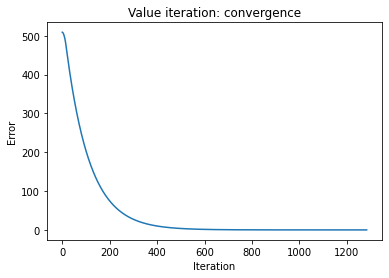

In [9]:
# Parameters
tol = 1e-5
gamma = 0.99

# Environment
env = get_env()

# run value iteration to obtain Q-values
VI_Q, VI_greedypol, all_qfunctions = value_iteration(env.P, env.R, gamma=gamma, tol=tol)

# render the policy
print("[VI]Greedy policy: ")
render_policy(env, VI_greedypol)

# compute the value function of the greedy policy using matrix inversion
# ====================================================
# YOUR IMPLEMENTATION HERE 
# compute value function of the greedy policy
#
Ns, Na = env.R.shape
policy = VI_greedypol
Rpi = np.array([env.R[s, policy[s]] for s in range(Ns)])
Ppi = np.array([env.P[s, policy[s]] for s in range(Ns)])
greedy_V = np.linalg.inv(np.eye(Ns) - gamma*Ppi)@Rpi
# ====================================================

# show the error between the computed V-functions and the final V-function
# (that should be the optimal one, if correctly implemented)
# as a function of time
final_V = all_qfunctions[-1].max(axis=1)
norms = [ np.linalg.norm(q.max(axis=1) - final_V) for q in all_qfunctions]
plt.plot(norms)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title("Value iteration: convergence")

#### POLICY ITERATION ####
PI_policy, PI_V = policy_iteration(env.P, env.R, gamma=gamma, tol=tol)
print("\n[PI]final policy: ")
render_policy(env, PI_policy)

## Uncomment below to check that everything is correct
assert np.allclose(PI_policy, VI_greedypol),\
     "You should check the code, the greedy policy computed by VI is not equal to the solution of PI"
assert np.allclose(PI_V, greedy_V),\
    "Since the policies are equal, even the value function should be"

plt.show()

# Part 2 - Tabular RL

## Question 2.1

The code below collects two datasets of transitions (containing states, actions, rewards and next states) for a discrete MDP.

For each of the datasets:

1. Estimate the transitions and rewards, $\hat{P}$ and $\hat{R}$.
2. Compute the optimal value function and the optimal policy with respect to the estimated MDP (defined by $\hat{P}$ and $\hat{R}$), which we denote by $\hat{\pi}$ and $\hat{V}$.
3. Numerically compare the performance of $\hat{\pi}$ and $\pi^\star$ (the true optimal policy), and the error between $\hat{V}$ and $V^*$ (the true optimal value function).

Which of the two data collection methods do you think is better? Why?

### **Answer**

The second data collection, the one that samples uniformly, seems to be better. Intuitively the second data collection will better explore the states. This is because there are states $s$ that have a lower probability to be visited (when always starting from the same state) so the corresponding $P(s, a)$ will be poorly estimated while other will be well estimated. With the second strategy, each state has the same probability of being drawn so at least each $P(s,a)$ will be equally estimated.
</br>
Here there are 31 states, 4 actions and we draw 500 samples. So each pair $s,a$ has about 500/4*31 = 4 samples to estimate all the $P(s,a,s')$ (at most 4 of them are non zero here and the probabilities are extremes values of $[0,1]$) so this seems not too bad.
</br>
If we run the code below several times we see that almost always the agent reaches the terminal state with the second data collection while in the first data collection the agent is almost always stuck at the wall.

In [10]:
def get_random_policy_dataset(env, n_samples):
  """Get a dataset following a random policy to collect data."""
  states = []
  actions = []
  rewards = []
  next_states = []
  
  state = env.reset()
  for _ in range(n_samples):
    action = env.action_space.sample()
    next_state, reward, is_terminal, info = env.step(action)
    states.append(state)
    actions.append(action)
    rewards.append(reward)
    next_states.append(next_state)
    # update state
    state = next_state
    if is_terminal:
      state = env.reset()

  dataset = (states, actions, rewards, next_states)
  return dataset

def get_uniform_dataset(env, n_samples):
  """Get a dataset by uniformly sampling states and actions."""
  states = []
  actions = []
  rewards = []
  next_states = []
  for _ in range(n_samples):
    state = env.observation_space.sample()
    action = env.action_space.sample()
    next_state, reward, is_terminal, info = env.sample(state, action)
    states.append(state)
    actions.append(action)
    rewards.append(reward)
    next_states.append(next_state)

  dataset = (states, actions, rewards, next_states)
  return dataset

# Collect two different datasets
num_samples = 500
env = get_env()
dataset_1 = get_random_policy_dataset(env, num_samples)
dataset_2 = get_uniform_dataset(env, num_samples)


# Item 3: Estimate the MDP with the two datasets; compare the optimal value
# functions in the true and in the estimated MDPs

#dataset 1
Ns, Na = env.R.shape
P1 = np.zeros((Ns, Na, Ns))
N1 = np.zeros((Ns, Na))
R1 = np.zeros((Ns, Na))

for i in range(num_samples):
  s, a, r, ns = dataset_1[0][i], dataset_1[1][i], dataset_1[2][i], dataset_1[3][i]
  N1[s, a] += 1
  R1[s, a] += r
  P1[s, a, ns] += 1
for s in range(Ns):
  for a in range(Na):
    P1[s, a]/=max(N1[s, a], 1)
    R1[s, a]/=max(N1[s, a], 1)
#we use policy iteration to compute the optimal policy / value function
PI_policy_1, PI_V_1 = policy_iteration(P1, R1, gamma=gamma, tol=tol)
print("Optimal policy of estimated P of first dataset")
print("Infinity norm error: ", np.linalg.norm(PI_V-PI_V_1, ord=np.inf))
render_policy(env, PI_policy_1)

#dataset 2
Ns, Na = env.R.shape
P1 = np.zeros((Ns, Na, Ns))
N1 = np.zeros((Ns, Na))
R1 = np.zeros((Ns, Na))

for i in range(num_samples):
  s, a, r, ns = dataset_2[0][i], dataset_2[1][i], dataset_2[2][i], dataset_2[3][i]
  N1[s, a] += 1
  R1[s, a] += r
  P1[s, a, ns] += 1
for s in range(Ns):
  for a in range(Na):
    P1[s, a]/=max(N1[s, a], 1)
    R1[s, a]/=max(N1[s, a], 1)
#we use policy iteration to compute the optimal policy / value function
PI_policy_1, PI_V_1 = policy_iteration(P1, R1, gamma=gamma, tol=tol)
print("Optimal policy of estimated P of second dataset")
print("Infinity norm error: ", np.linalg.norm(PI_V-PI_V_1, ord=np.inf))
render_policy(env, PI_policy_1)
# ...

Optimal policy of estimated P of first dataset
Infinity norm error:  99.99998992565207


Optimal policy of estimated P of second dataset
Infinity norm error:  1.6149832405864686


## Question 2.2

Suppose that $\hat{P}$ and $\hat{R}$ are estimated from a dataset of exactly $N$ i.i.d. samples from **each** state-action pair. This means that, for each $(s,a)$, we have $N$ samples $\{(s_1',r_1, \dots, s_N', r_N\}$, where $s_i' \sim P(\cdot | s,a)$ and $r_i \sim R(s,a)$ for $i=1,\dots,N$, and
$$ \hat{P}(s'|s,a) = \frac{1}{N}\sum_{i=1}^N \mathbb{1}(s_i' = s'), $$
$$ \hat{R}(s,a) = \frac{1}{N}\sum_{i=1}^N r_i.$$
Suppose that $R$ is a distribution with support in $[0,1]$. Let $\hat{V}$ be the optimal value function computed in the empirical MDP (i.e., the one with transitions $\hat{P}$ and rewards $\hat{R}$). For any $\delta\in(0,1)$, derive an upper bound to the error

$$ \| \hat{V} - V^* \|_\infty $$

which holds with probability at least $1-\delta$.

**Note** Your bound should only depend on deterministic quantities like $N$, $\gamma$, $\delta$, $S$, $A$. It should *not* dependent on the actual random samples.

**Hint** The following two inequalities may be helpful.

1. **A (simplified) lemma**. For any state $\bar{s}$,

$$ |\hat{V}(\bar{s}) - V^*(\bar{s})| \leq \frac{1}{1-\gamma}\max_{s,a} \left| R(s,a) - \hat{R}(s,a) + \gamma \sum_{s'}(P(s'|s,a) - \hat{P}(s'|s,a)) V^*(s') \right|$$

2. **Hoeffding's inequality**. Let $X_1, \dots X_N$ be $N$ i.i.d. random variables bounded in the interval $[0,b]$ for some $b>0$. Let $\bar{X} = \frac{1}{N}\sum_{i=1}^N X_i$ be the empirical mean. Then, for any $\epsilon > 0$,

$$ \mathbb{P}(|\bar{X} - \mathbb{E}[\bar{X}]| > \epsilon) \leq 2e^{-\frac{2N\epsilon^2}{b^2}}.$$

### **Answer**

Basically, we want to write an inequality of this form:

$$ \mathbb{P}(\| \hat{V} - V^* \|_\infty> f(\delta)) \leq \delta $$

With some function $f(\delta)$ that only depends on $ \delta $ (and maybe some constants of the problem) that we have to find.
</br>
First, using the first lemma:
$$ \mathbb{P}(\| \hat{V} - V^* \|_\infty> \epsilon) \leq \mathbb{P}(\max_{s,a} |X(s,a) - \mathbb{E}[X(s,a)]|>\epsilon')$$
with $\epsilon '= (1-\gamma) \epsilon $ and $X(s,a) = \hat{R}(s,a) + \gamma\sum_{s'}\hat{P}(s'|s,a)V^*(s')$, which can be written as $X(s,a) = \frac{1}{N}\sum_i (r_i + \gamma V^*(s_i'))$. Furthermore:
$$(\max_{s,a} |X(s,a) - \mathbb{E}[X(s,a)]|>\epsilon')=\bigcup_{s, a} (|X(s,a) - \mathbb{E}[X(s,a)]|>\epsilon')$$
By upper bounding the probability of the union by the sum of the probabilities:
$$\mathbb{P}(\| \hat{V} - V^* \|_\infty> \epsilon) \leq \sum_{s,a} \mathbb{P}(|X(s,a) - \mathbb{E}[X(s,a)]|>\epsilon')$$
Because the $(r_i, s_i')$ are i.i.d. we should use Hoeffding's lemma on each $(s,a)$:
$$\mathbb{P}(\| \hat{V} - V^* \|_\infty> \epsilon) \leq 2|S||A|e^{-2N(1-\gamma)^4\epsilon^2}$$
Because here each $r_i$ has support in $[0,1]$ and because the actual reward is bounded by one $V^*(s) \leq \frac{1}{1-\gamma}$ for any state $s$.
</br>
Writing $\delta = 2|S||A|e^{-2N(1-\gamma)^4\epsilon^2}$, we eventually get :
$$\mathbb{P}(\| \hat{V} - V^* \|_\infty >\sqrt{\frac{\log(\frac{1}{\delta}) + \log(2|S||A|)}{2N(1-\gamma)^4}}) \leq \delta$$



## Question 2.3

Suppose once again that we are given a dataset of $N$ samples in the form of tuples $(s_i,a_i,s_i',r_i)$. We know that each tuple contains a valid transition from the true MDP, i.e., $s_i' \sim P(\cdot | s_i, a_i)$ and $r_i \sim R(s_i,a_i)$, while the state-action pairs $(s_i,a_i)$ from which the transition started can be arbitrary.

Suppose we want to apply Q-learning to this MDP. Can you think of a way to leverage this offline data to improve the sample-efficiency of the algorithm? What if we were using SARSA instead?

### **Answer**

For Q-learning, we could use our dataset to observe next state and reward according to our estimates of the parameters $P, R$, if we have a correspoding  transition in our dataset. In fact this would delete the cost of actually doing the action in the environment.

# Part 3 - RL with Function Approximation

## Question 3.1

Given a datset $(s_i, a_i, r_i, s_i')$ of (states, actions, rewards, next states), the Fitted Q-Iteration (FQI) algorithm proceeds as follows:


* We start from a $Q$ function $Q_0 \in \mathcal{F}$, where $\mathcal{F}$ is a function space;
* At every iteration $k$, we compute $Q_{k+1}$ as:

$$
Q_{k+1}\in\arg\min_{f\in\mathcal{F}} \frac{1}{2}\sum_{i=1}^N
\left(
  f(s_i, a_i) - y_i^k
\right)^2 + \lambda \Omega(f)
$$
where $y_i^k = r_i + \gamma \max_{a'}Q_k(s_i', a')$, $\Omega(f)$ is a regularization term and $\lambda > 0$ is the regularization coefficient.


Consider FQI with *linear* function approximation. That is, for a given feature map $\phi : S \rightarrow \mathbb{R}^d$, we consider a parametric family of $Q$ functions $Q_\theta(s,a) = \phi(s)^T\theta_a$ for $\theta_a\in\mathbb{R}^d$. Suppose we are applying FQI on a given dataset of $N$ tuples of the form $(s_i, a_i, r_i, s_i')$ and we are at the $k$-th iteration. Let $\theta_k \in\mathbb{R}^{d \times A}$ be our current parameter. Derive the *closed-form* update to find $\theta_{k+1}$, using $\frac{1}{2}\sum_a ||\theta_a||_2^2$ as regularization.

### **Answer**

Let $F_k(\theta)= \frac{1}{2}\sum_{i=1}^N \left(\phi(s_i)^T\theta_{a_i}- y_i^k\right)^2 +\lambda \Omega(f)$ , with $\theta$ a parameter of dimensions $(d, A)$. We want to find a minimizer of $F_k$ so we set $\nabla_{\theta_a}F_k(\theta) = 0$ for every $a \in A$:
$$\nabla_{\theta_a}(\theta) = 0$$
$$\Longleftrightarrow \sum_{i=1, a_i=a}^N{\phi(s_i)(\phi(s_i)^T\theta_a - y_i^k)} + \lambda\theta_a = 0$$
$$\Longleftrightarrow [\lambda I_d + \sum_{i=1, a_i=a}^N{\phi(s_i)\phi(s_i)^T]}\theta_a= \sum_{i=1, a_i=a}^N{\phi(s_i)y_i^k} $$
$$\Longleftrightarrow \theta_a= [\lambda I_d + \sum_{i=1, a_i=a}^N{\phi(s_i)\phi(s_i)^T}]^{-1}\sum_{i=1, a_i=a}^N{\phi(s_i)y_i^k} $$

which holds for every $a$. So the update is:
$$ \forall a, \space \theta_{k+1,a}= [\lambda I_d + \sum_{i=1, a_i=a}^N{\phi(s_i)\phi(s_i)^T}]^{-1}\sum_{i=1, a_i=a}^N{\phi(s_i)y_i^k} $$
where $\theta_k$ is 'hidden' in $y_i^k$.

## Question 3.2

The code below creates a larger gridworld (with more states than the one used in the previous questions), and defines a feature map. Implement linear FQI to this environment (in the function `linear_fqi()` below), and compare the approximated $Q$ function to the optimal $Q$ function computed with value iteration.

Can you improve the feature map in order to reduce the approximation error?

### **Answer**

Increasing the value of $dim$ and the value of $sigma$ can help reducing the approximation error though it might also lead to overfitting. We can also increase the number of samples taken to better estimate the parameters $P, R$ of our MDP. In our case increasing $dim$ from $15$ to $50$ and $n$_$samples$ from $500$ to $2000$ led already to decent results, the agent reaching the goal.
</br>
Moreover, we could change the similarity matrix has to better take into account the walls. For example, the $dist$ value in the similarity matrix for two points of the grid could be set to the length of the shortest path in the associated graph of the grid or even to infinity in order to discourage the agent to take an action that will make him go into the wall.

In [11]:
def get_large_gridworld():
  """Creates an instance of a grid-world MDP with more states."""
  walls = [(ii, 10) for ii in range(15) if (ii != 7 and ii != 8)]
  env = GridWorld(
      nrows=15,
      ncols=15,
      reward_at = {(14, 14):1.0},
      walls=tuple(walls),
      success_probability=0.9,
      terminal_states=((14, 14),)
  )
  return env


class GridWorldFeatureMap:
  """Create features for state-action pairs
  
  Args:
    dim: int
      Feature dimension
    sigma: float
      RBF kernel bandwidth
  """
  def __init__(self, env, dim=15, sigma=0.25):
    self.index2coord = env.index2coord
    self.n_states = env.Ns
    self.n_actions = env.Na
    self.dim = dim
    self.sigma = sigma

    n_rows = env.nrows
    n_cols = env.ncols

    # build similarity matrix
    sim_matrix = np.zeros((self.n_states, self.n_states))
    for ii in range(self.n_states):
        row_ii, col_ii = self.index2coord[ii]
        x_ii = row_ii / n_rows
        y_ii = col_ii / n_cols
        for jj in range(self.n_states):
            row_jj, col_jj = self.index2coord[jj]
            x_jj = row_jj / n_rows
            y_jj = col_jj / n_cols
            dist = np.sqrt((x_jj - x_ii) ** 2.0 + (y_jj - y_ii) ** 2.0)
            sim_matrix[ii, jj] = np.exp(-(dist / sigma) ** 2.0)

    # factorize similarity matrix to obtain features
    uu, ss, vh = np.linalg.svd(sim_matrix, hermitian=True)
    self.feats = vh[:dim, :]

  def map(self, observation):
    feat = self.feats[:, observation].copy()
    return feat

In [12]:
env = get_large_gridworld()
feat_map = GridWorldFeatureMap(env)

# Visualize large gridworld
render_policy(env)

# The features have dimension (feature_dim).
feature_example = feat_map.map(1) # feature representation of s=1
print(feature_example)

# Initial vector theta representing the Q function
theta = np.zeros((feat_map.dim, env.action_space.n))
print(theta.shape)
print(feature_example @ theta) # approximation of Q(s=1, a)

[-0.02850699  0.063555   -0.02169407 -0.06441918  0.04505794 -0.07537777
  0.08506473 -0.09325287  0.09644275 -0.00535101  0.11632395 -0.13074085
  0.00921342 -0.13853662  0.07118419]
(15, 4)
[0. 0. 0. 0.]


(4, 50, 50) (4, 50, 50)


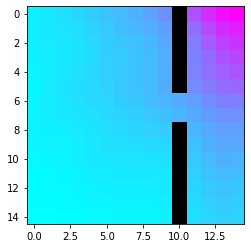

In [13]:
def linear_fqi(env, feat_map, num_iterations, lambd=0.1, gamma=0.95):
  """
  # Linear FQI implementation
  # TO BE COMPLETED
  """

  # get a dataset
  n_samples = 2000
  dataset = get_uniform_dataset(env, n_samples=n_samples)
  # OR dataset = get_random_policy_dataset(env, n_samples=...)


  theta = np.zeros((feat_map.dim, env.Na))
  M = np.array([np.array([[feat_map.map(dataset[0][i])[k]*feat_map.map(dataset[0][i])[l] for l in range(feat_map.dim)] for k in range(feat_map.dim)]) for i in range(n_samples)])
  S = np.array([np.sum(np.array([M[i] for i in range(n_samples) if dataset[1][i]==a]), axis=0) for a in range(env.Na)])
  X = np.array([np.linalg.inv(lambd*np.eye(feat_map.dim) + S[a]) for a in range(env.Na)])
  print(S.shape, X.shape)
  for it in range(num_iterations):
    yk = np.array([dataset[2][i]+gamma*np.max(np.array([feat_map.map(dataset[3][i]).T@theta[:,a] for a in range(env.Na)])) for i in range(n_samples)])
    for a in range(env.Na):
      Y = np.sum(np.array([yk[i]*feat_map.map(dataset[0][i]) for i in range(n_samples) if dataset[1][i]==a]), axis=0)
      theta[:, a] = X[a]@Y
  return theta

# ----------------------------
# Environment and feature map
# ----------------------------
env = get_large_gridworld()
# you can change the parameters of the feature map, and even try other maps!
feat_map = GridWorldFeatureMap(env, dim=50, sigma=0.25)

# -------
# Run FQI
# -------
theta = linear_fqi(env, feat_map, num_iterations=100)

# Compute and run greedy policy
Q_fqi = np.zeros((env.Ns, env.Na))
for ss in range(env.Ns):
  state_feat = feat_map.map(ss)
  Q_fqi[ss, :] = state_feat @ theta

V_fqi = Q_fqi.max(axis=1)
policy_fqi = Q_fqi.argmax(axis=1)
render_policy(env, policy_fqi, horizon=100)

# Visualize the approximate value function in the gridworld.
img = env.get_layout_img(V_fqi)    
plt.imshow(img)
plt.show()